## Projet 6 : Classifiez automatiquement des biens de consommation

## Contexte

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image.

## Librairies utilisées avec le langage Python:

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from gensim.models.phrases import Phrases
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.util import ngrams
from wordcloud import WordCloud
from pandarallel import pandarallel
pandarallel.initialize()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import multiprocessing
import os
import warnings
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')

pandarallel.initialize(progress_bar=True, nb_workers = 6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celine.lesur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Données textuelles brutes:

In [3]:
# Importation de data :
data = pd.read_csv('D:/tutorial-env/OCR/Projet6/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
data.shape

(1050, 15)

In [5]:
data.describe(include = 'all')

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1049.000000,1049.000000,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,NaN,NaN,1050,2,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,NaN,NaN,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,NaN,NaN,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,NaN,2186.197331,1584.527169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,7639.229411,7475.099680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,555.000000,340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,999.000000,600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1999.000000,1199.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Le dataframe textuelle contient 15 variables et 1050 produits.

## Création du dataframe de classification textuelle :

Nous ne garderons que les variables intéressantes pour notre cas d'usage, c'est à dire la classification des descriptions textuelles et des images des produits.

Gardons les variables :
- product_name (identifiant unique produit),
- product_category_tree (classification cible),
- image (référence unique à l'image produit),
- description (données à classifier).


In [6]:
# Dataframe des variables sélectionnées :
data_txt = data [[
    'product_name',
    'description',
    'image',
    'product_category_tree'
    ]]

data_txt.head()

,product_name,description,image,product_category_tree
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>..."
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."


In [7]:
data_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_name           1050 non-null   object
 1   description            1050 non-null   object
 2   image                  1050 non-null   object
 3   product_category_tree  1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


In [8]:
# Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data : pd.DataFrame) -> pd.DataFrame:

    '''Prend dataframe `data` en entrée et calcule le pourcentage de valeurs manquantes pour chaque colonne
    Args:
        data (pd.DataFrame): Dataframe sur lequel les pourcentages de valeurs manquantes seront calculées
    Sortie:
        pd.DataFrame: Dataframe avec le pourcentage de valeurs manquantes pour chaque colonne

    '''
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        #Calcul du pourcentage de valeurs manquantes
        miss_val.append(data[item].isna().mean())

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    num_total_vars = data.shape[1]
    num_vars_missing = output[output['miss_val'] != 0].shape[0]
    print (f"Notre dataframe a  {num_total_vars} variables.\n"
           f"Il y a  {num_vars_missing} variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val'] != 0].sort_values('miss_val')


In [9]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_txt_vm = show_miss_val(data_txt)
data_txt_vm.head(5)

Notre dataframe a  4 variables.
Il y a  0 variables contenant des valeurs manquantes.


,variable,miss_val


Notre dataframe de classification textuelle contient 4 variables et 1050 produits.

Aucune valeur manquante n'est présente dans ce dataframe.

In [10]:
data_txt.duplicated().sum()

0

Aucun doublon n'est présent dans notre dataframe de classification textuelle, ce qui est en adéquation avec le faitque nous ayons gardé des variables qui ont autant de "catégories" que de produits, excepté la variable product_category_tree (cible de classification).

Il n'y a pas de nettoyage spécifique à faire dans notre dataframe de classification textuelle.

## Analyse exploratoire univariée :

### Cible : product_category_tree

Commençons pas séparer cette colonne avec un "arbre de catégories" avec 642 valeurs uniques, ce qui est trop élevé, en plusieurs colonnes par niveau de l'arbre des catégories.

In [11]:
#Traitement des catégories
def separation_categories(data : pd.DataFrame,
                          col : str)-> pd.DataFrame :
    '''Prend une colonne 'col' de dataframe `data` en entrée contenant un arbre de catégorie et la sépare en plusieurs colonnes par niveau de catégorie
    Args:
        data (pd.DataFrame): Dataframe à analyser
        col (str): Nom de la colonne à séparer
    Sortie:
        pd.DataFrame: Dataframe avec les arbres de catégories séparées en plusieurs colonnes

    '''
    for  items in data[col]:
      item = items.split('["')[1].split('"]')[0]
      cat = item.split(' >> ')
      nb_cat = len(cat)
      for n in range (0, nb_cat):
        name_col = 'cat_niv_' + str(n + 1)
        if name_col not in data.columns:
          data[name_col] = np.nan
        data.loc[data[col] == items,name_col] = cat[n]
    return data

In [12]:
data_txt_sep = separation_categories(data_txt, 'product_category_tree')
data_txt_sep

,product_name,description,image,product_category_tree,cat_niv_1,cat_niv_2,cat_niv_3,cat_niv_4,cat_niv_5,cat_niv_6,cat_niv_7
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,NaN,NaN,NaN
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",NaN,NaN
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,NaN,NaN
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,NaN,NaN
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,NaN,NaN,NaN
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,NaN,NaN,NaN
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,NaN,NaN,NaN
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,NaN,NaN,NaN


In [13]:
data_txt_sep.describe(include = 'all')

,product_name,description,image,product_category_tree,cat_niv_1,cat_niv_2,cat_niv_3,cat_niv_4,cat_niv_5,cat_niv_6,cat_niv_7
count,1050,1050,1050,1050,1050,1050,1047,679,405,127,57
unique,1050,1050,1050,642,7,62,241,349,297,117,57
top,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",Home Furnishing,Wrist Watches,Deodorants,Combos,Dresses,Wow! Dresses,Mom and Kid Baby Girl's Printed Green Top & Py...
freq,1,1,1,56,150,149,65,64,21,3,1


Les arbres de catégories contiennent jusqu'à 7 niveaux.

In [14]:
data_txt_sep_vm = show_miss_val(data_txt_sep)
data_txt_sep_vm.head(10)

Notre dataframe a  11 variables.
Il y a  5 variables contenant des valeurs manquantes.


,variable,miss_val
6,cat_niv_3,0.002857
7,cat_niv_4,0.353333
8,cat_niv_5,0.614286
9,cat_niv_6,0.879048
10,cat_niv_7,0.945714


Au vu du nombre de valeurs uniques et de valeurs manquantes, gardons seulement les deux premières catégories et étudions les :

In [15]:
# Suppression des colonnes inutiles
data_txt_sep.drop(columns = ['cat_niv_3', 'cat_niv_4', 'cat_niv_5', 'cat_niv_6', 'cat_niv_7'], inplace = True)
data_txt_sep.head()

,product_name,description,image,product_category_tree,cat_niv_1,cat_niv_2
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing,Curtains & Accessories
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen


In [16]:
def describe_data_qual(data: pd.DataFrame,
                    col: str) :
    '''Génère des visualisation graphiques pour une colonne catégorielle d'un dataframe
    Args:
        data (pd.DataFrame): Dataframe contenant les données à analyser
        col (str): Nom de la colonne que l'on veut analyser
    Sortie:
        Histogramme des fréquences des catégories de la colonne
        Diagramme circulaire des fréquences des catégories de la colonne
    '''
    # Filtrage des données nulles
    mask = data[col].notnull()
    df = data[mask]

    # Données à visualiser
    x=df[col]

    # Fréquences et étiquettes triées par index
    labels = list(x.value_counts().sort_values(ascending = False).index.astype(str))
    frequencies = x.value_counts().sort_values(ascending = False)

    # Propriétés graphiques de la figure principale
    fig = plt.figure(figsize=(18,10))
    plt.suptitle(f"Distribution de : {col}", fontsize=25)

    # Propriétés graphiques du premier graphique (histogramme)
    ax1 = plt.subplot(121)
    ax1.set_ylabel(col, fontsize=20)
    ax1.set_xlabel("Frequences", fontsize=20)

    # Propriétés graphiques du deuxième graphique (diagramme circulaire)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Frequences en %", fontsize=20)

    # Tracer les graphiques
    ax1.barh(labels, frequencies)
    ax2.pie(frequencies,autopct='%1.2f%%',shadow=True )

    # Ajouter une légende
    ax2.legend(labels, loc = 'upper right', bbox_to_anchor = (1.5, 1))

    # Afficher les graphiques
    plt.show()

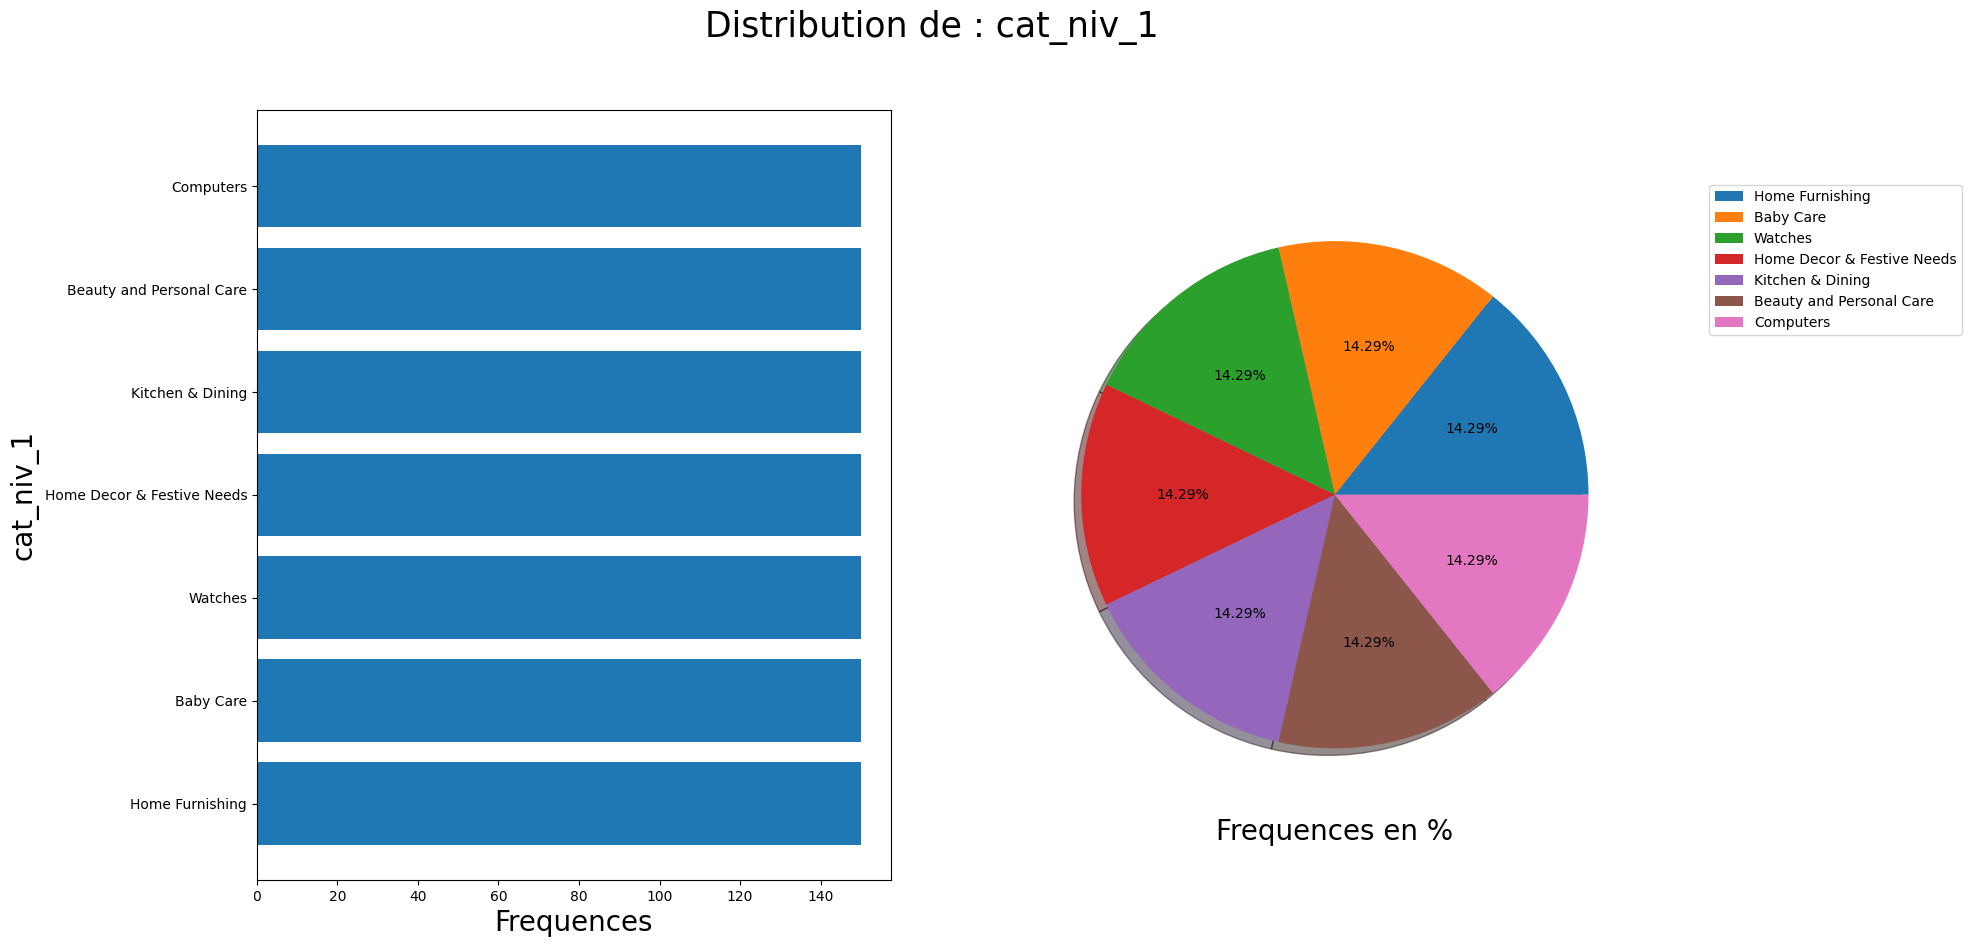

In [17]:
describe_data_qual(data_txt_sep, 'cat_niv_1')

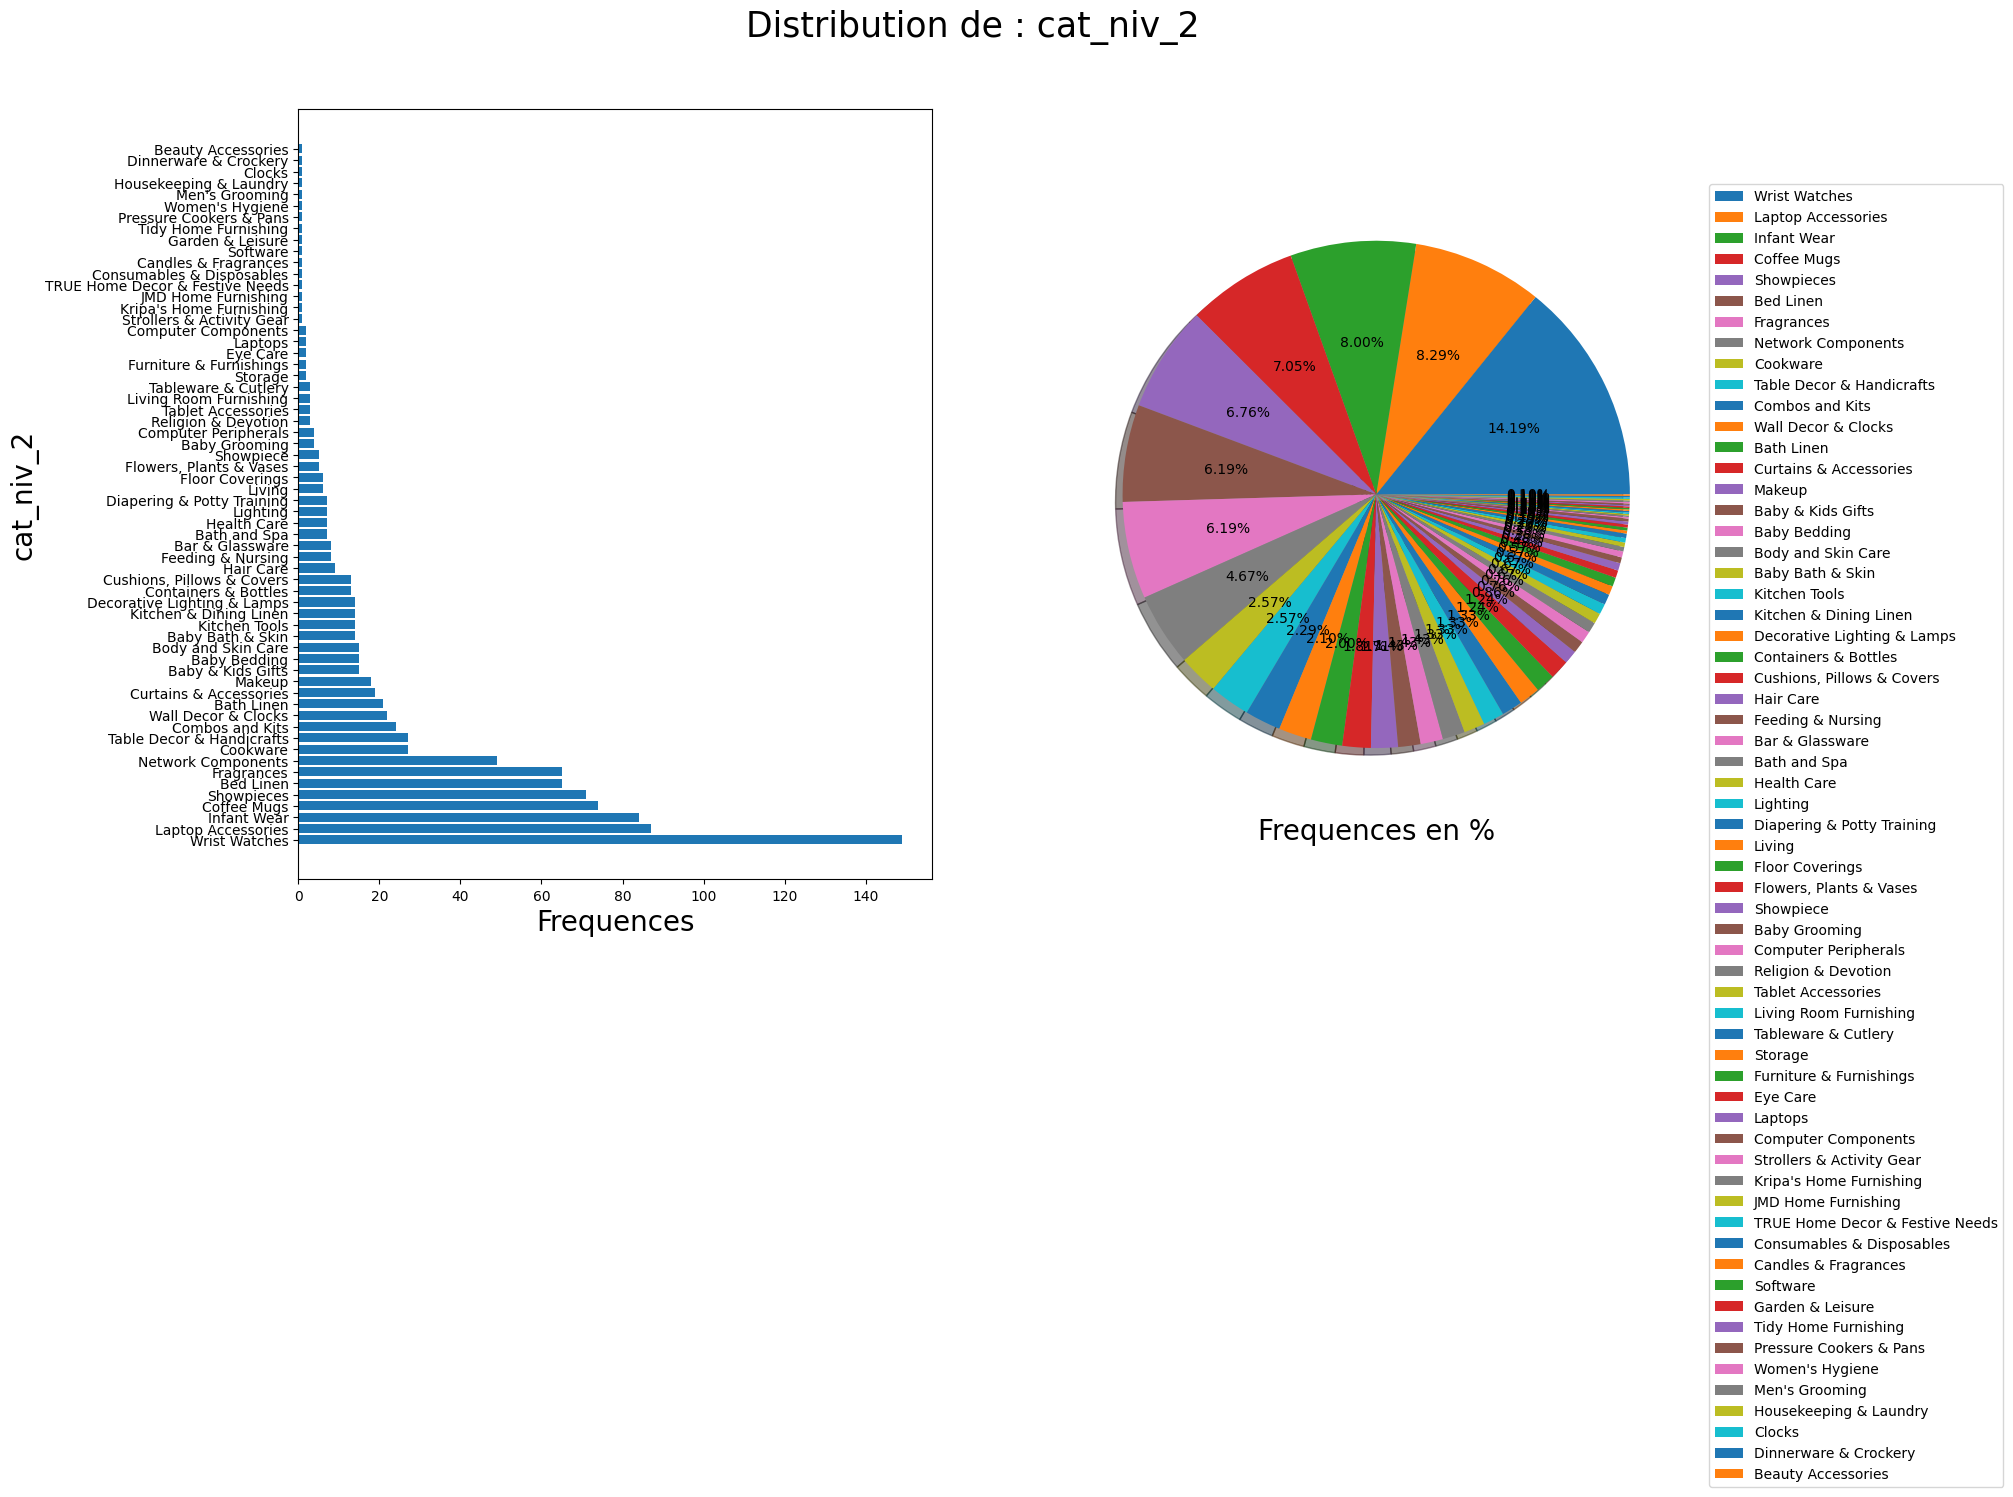

In [18]:
describe_data_qual(data_txt_sep, 'cat_niv_2')

Certaines catégories de niveau 2 sont très largement sous-représentées par rapport aux autres, concentrons-nous donc seulement sur la première catégorie pour la classification.

### Variable texte : description

In [19]:
data_txt_sep.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

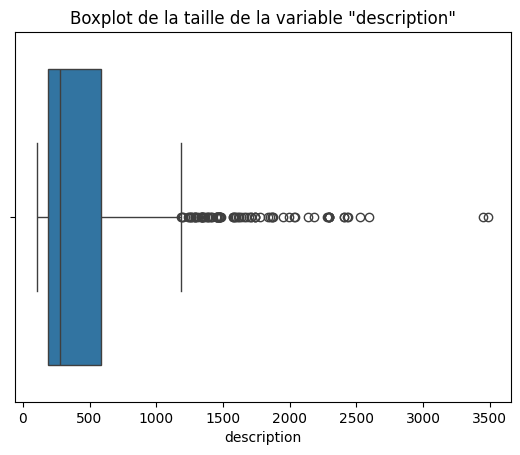

In [20]:
tmp=data_txt_sep.description.str.len()
sns.boxplot(x = tmp, orient = 'h')
plt.title(f'Boxplot de la taille de la variable "description"')
plt.show()

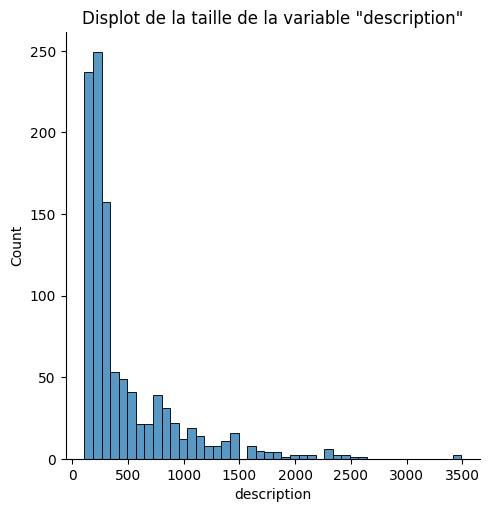

In [21]:
sns.displot(tmp)
plt.title(f'Displot de la taille de la variable "description"')
plt.show()

Peu de textes descriptifs ont une taille supérieure à 1200 caractères. La grande majorité a une taille inférieure à 300 caractères.

Ajoutons la taille au dataframe :

In [22]:
data_txt_sep['_taille_description'] = tmp
data_txt_sep

,product_name,description,image,product_category_tree,cat_niv_1,cat_niv_2,_taille_description
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing,Curtains & Accessories,1420
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,444
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,1258
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,858
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,1197
...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,2432
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,1660
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,262
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,210


## Analyse exploratoire multivariée :


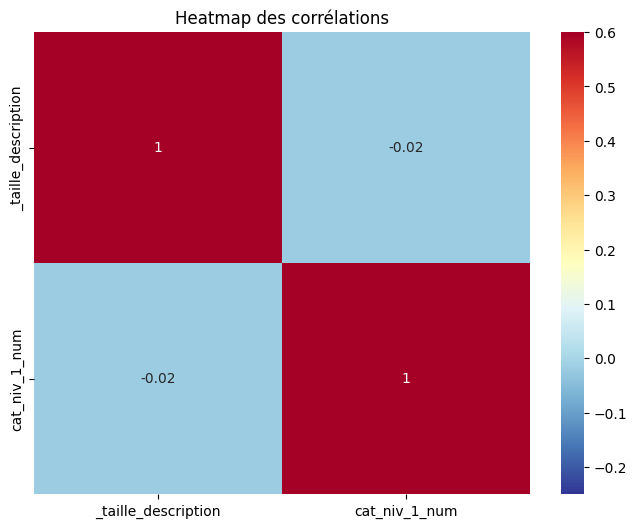

In [23]:
encoder = LabelEncoder()

# Encodage de la variable cat_niv_1
data_txt_sep['cat_niv_1_num'] = encoder.fit_transform(data_txt_sep['cat_niv_1'])

plt.figure(figsize = (8, 6))

# Sélection des colonnes numériques
data_corr = data_txt_sep.select_dtypes(include=['int64', 'int32'])

# Heatmap des correlations
sns.heatmap(data_corr.corr(),
            cmap = plt.cm.RdYlBu_r,
            vmin = -0.25,
            vmax = 0.6,
            annot = True)
plt.title('Heatmap des corrélations')
plt.show()

Il apparait qu'il n'existe pas de corrélation entre la taille des descriptions et la catégorie du produit.

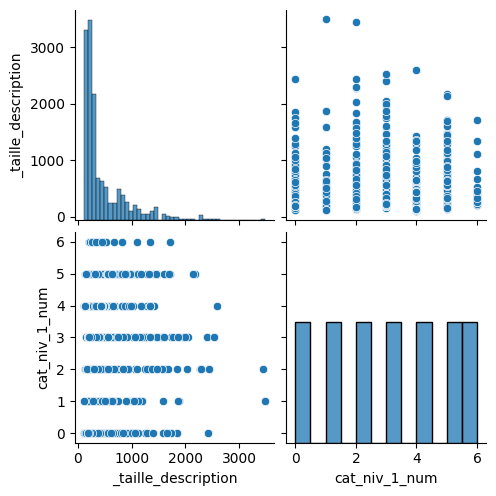

In [24]:
sns.pairplot(data_corr)
plt.show()

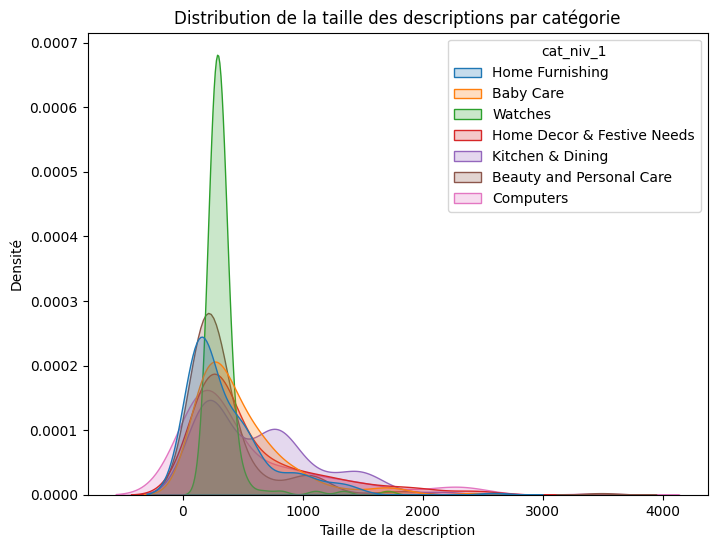

In [25]:
plt.figure(figsize = (8, 6))
sns.kdeplot( x = '_taille_description', hue = 'cat_niv_1', data = data_txt_sep, fill = True)
plt.title('Distribution de la taille des descriptions par catégorie')
plt.xlabel('Taille de la description')
plt.ylabel('Densité')
plt.show()

Les distributions des tailles de descriptions sont assez similaires entre les différentes catégories.

On peut cependant noter que la distribution est plus concentrée autour de 300 caractères pour la catégorie "Watches" et qu'il y a plus de descriptions longues dans la catégorie "Kitchen and Dining" comparé aux autres.

## Traitement des données de la variable "description" :

### Recherche de la meilleure tokenisation

In [26]:
# Sélection de 10 descriptions au hasard :
txt = []
for i in range (0, 10) :
     txt.append(data_txt_sep['description'].sample(1).values[0].lower())
display(txt)


['key features of craftcart parrot antique brass key holder pack of: 1 shape: parrot mount mechanism: screw-in,craftcart parrot antique brass key holder (5 hooks, brown) price: rs. 350 designer brass key holder,specifications of craftcart parrot antique brass key holder (5 hooks, brown) general brand craftcart shape parrot model number kh-parrot-a model name parrot antique material brass finish antique number of hooks 5 mount mechanism screw-in color brown in the box sales package 1 key holder pack of 1 dimensions weight 150 g height 11 cm width 14 cm depth 3 cm',
 'fastrack 38015pl01 analog watch  - for men, boys - buy fastrack 38015pl01 analog watch  - for men, boys  38015pl01 online at rs.2495 in india only at flipkart.com. stainless steel back cover. hybrid case construction for a sportier and more rugged look with increased shock resistance. high precision quartz analogue movement. - great discounts, only genuine products, 30 day replacement guarantee, free shipping. cash on deliv

In [27]:
# Initialisation de la liste de stopwords anglais
stopwords = set(stopwords.words('english'))

# Test de différentes tokenisations :
# le Word Tokenizer se base sur les espaces, le WordPunctTokenizer tient compte de la ponctuation et le RegexpTokenizer utilise des expressions régulières pour une segmentation plus flexible.
for i, doc in enumerate(txt):

    print('**'*50)
    print(f'---> doc_{i}\n')

    # Test de la tokenisation via word_tokenize avec filtrage des stops_words :
    print('Résultat avec word_tokenizer : \n')
    token = word_tokenize(doc)
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

    # Test de la tokenisation via wordpunct_tokenize avec filtrage des stops_words :
    print('--'*20)
    print('Résultat avec wordpunct_tokenize : \n')
    token = wordpunct_tokenize(doc)
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

    # Test de la tokenisation via RegexpTokenizer avec filtrage des stops_words :
    print('--'*20)
    print('Résultat avec RegexpTokenizer : \n')
    token = RegexpTokenizer(r'\w+').tokenize(doc) # ici le tokenizer ignore la ponctuation et sépare les mots en utilisant uniquement les caractères alphanumériques et le caractère de soulignement
    token = [w for w in token if w not in stopwords]
    print(len(token), len(set(token)))

****************************************************************************************************
---> doc_0

Résultat avec word_tokenizer : 

99 49
----------------------------------------
Résultat avec wordpunct_tokenize : 

104 50
----------------------------------------
Résultat avec RegexpTokenizer : 

87 44
****************************************************************************************************
---> doc_1

Résultat avec word_tokenizer : 

63 45
----------------------------------------
Résultat avec wordpunct_tokenize : 

67 47
----------------------------------------
Résultat avec RegexpTokenizer : 

50 43
****************************************************************************************************
---> doc_2

Résultat avec word_tokenizer : 

173 101
----------------------------------------
Résultat avec wordpunct_tokenize : 

185 103
----------------------------------------
Résultat avec RegexpTokenizer : 

147 96
*******************************************

La meilleure tokenisation est effectuée via RegexpTokenizer car c'est celui qui amène au minimum de token.

### Première fonction de pré-processing

In [28]:
def preprocess (txt: str,
                stopwords: list,
                n_gram_range = (1,3)) -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
  Sortie:
        Liste de tokens du texte sans stopwords
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += [' '.join(gram) for gram in ngrams(token_clean, n)]

  token_clean = token_clean + ngram

  return token_clean

### Personnalisation de la liste de stopwords

In [29]:
# Fusion de tout le corpus
corpus = " ".join( data_txt_sep['description'].values)
len(corpus)

498561

In [30]:
# Tokenisation sur tout le corpus
corpus_tokenised = preprocess(corpus, stopwords)
print(f"Il y a  {len(corpus_tokenised)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised))} tokens uniques.")

Il y a  247141 tokens.
Il y a  56890 tokens uniques.


In [31]:
# Transformation de la colonne "description" en tokens
tmp = pd.Series(corpus_tokenised).value_counts()
tmp.head(45)

rs                        1822
products                  1262
free                      1236
buy                       1162
delivery                  1134
cash                      1128
shipping                  1128
genuine                   1128
replacement               1118
1                         1108
cm                        1086
day                       1080
30                         996
flipkart                   962
com                        946
guarantee                  942
online                     792
features                   790
specifications             742
price                      704
watch                      660
color                      656
mug                        654
baby                       640
pack                       634
material                   624
set                        620
type                       608
cotton                     598
box                        584
general                    576
5                          572
shipping

In [32]:
tmp.tail(45)

size face towel                       1
cms specifications eurospa            1
face towel 23                         1
towel 23 cms                          1
23 cms x                              1
cms x 23                              1
x 23 cms                              1
23 cms specifications                 1
name shuvam20pcftsetassorted ideal    1
boys girls men                        1
printed wedding gifted                1
gifting specifications santosh        1
double bedsheet royal                 1
bedsheet royal bedsheet               1
royal bedsheet perfact                1
bedsheet perfact wedding              1
perfact wedding gifting               1
wedding gifting specifications        1
royal fashion machine                 1
package 20 piece                      1
fashion machine washable              1
name gold design                      1
gold design royal                     1
design royal cotton                   1
royal cotton printed                  1


In [33]:
tmp.describe()

count    56890.000000
mean         4.344191
std         28.384682
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1822.000000
Name: count, dtype: float64

50% des tokens ne sont présents qu'une ou deux fois ce qui parait peu pertinents pour une classification.

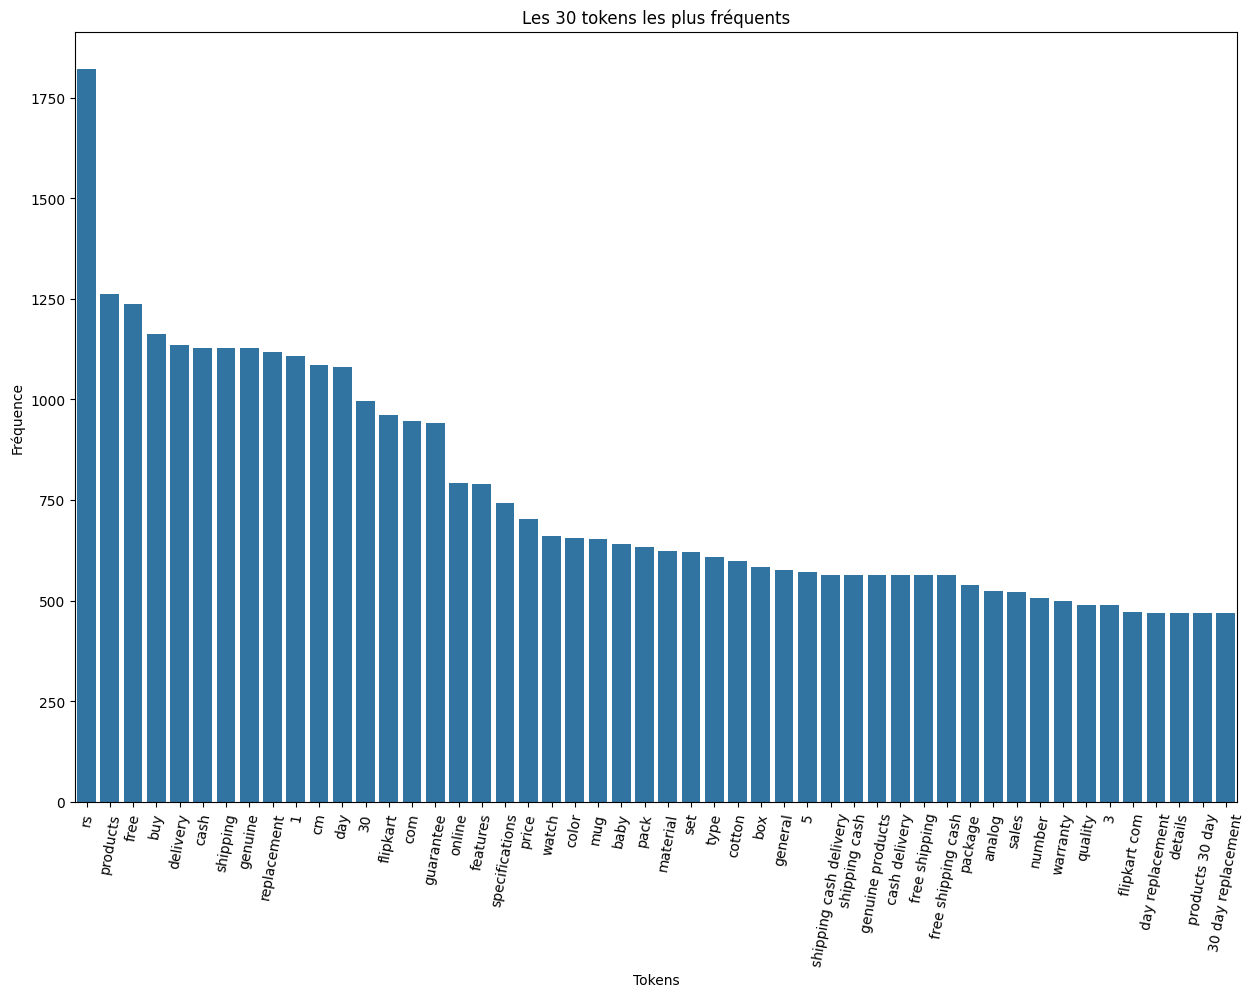

In [34]:
# Visualisation des 30 tokens les plus fréquents
plt.figure(figsize = (15,10))
sns.barplot(x = tmp.index[:50], y = tmp.values[:50])
plt.xticks(rotation = 80)
plt.title('Les 30 tokens les plus fréquents')
plt.xlabel('Tokens')
plt.ylabel('Fréquence')
plt.show()

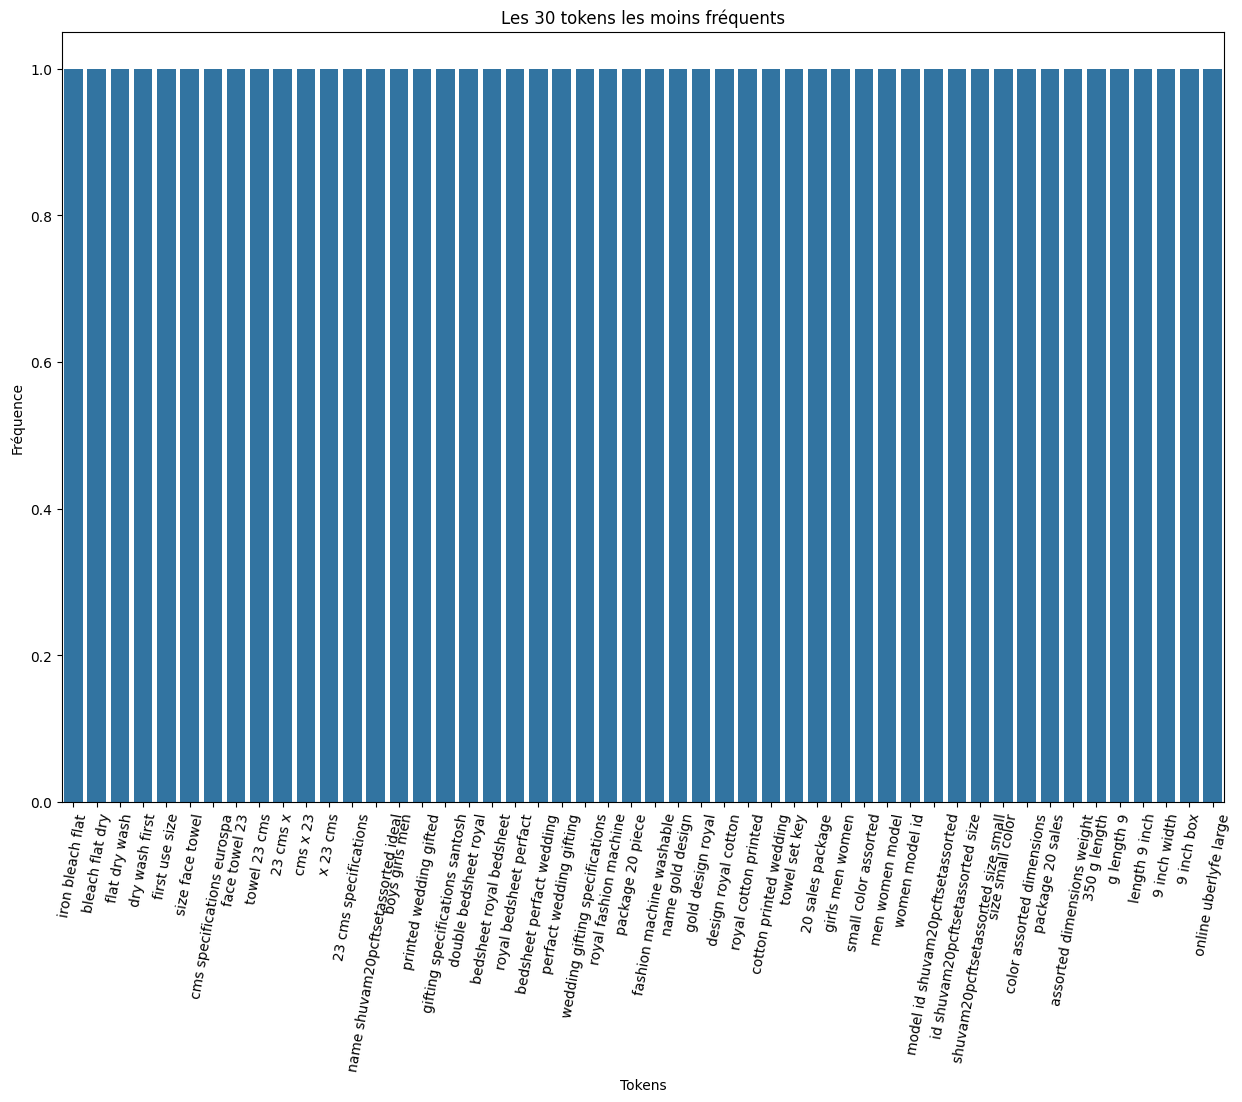

In [35]:
# Visualisation des 30 tokens les moins fréquents
plt.figure(figsize = (15,10))
sns.barplot(x = tmp.index[-50:], y = tmp.values[-50:])
plt.xticks(rotation = 80)
plt.title('Les 30 tokens les moins fréquents')
plt.xlabel('Tokens')
plt.ylabel('Fréquence')
plt.show()

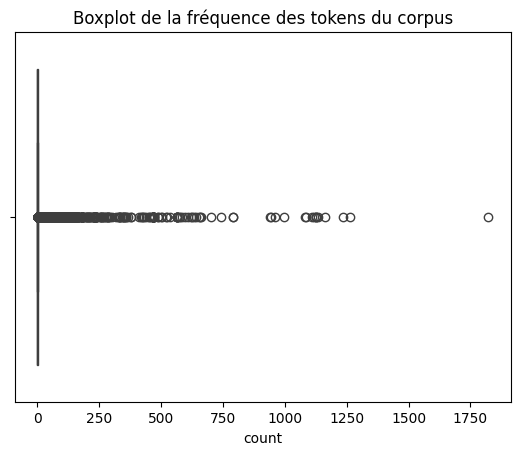

In [36]:
sns.boxplot(tmp, orient = 'h')
plt.title(f'Boxplot de la fréquence des tokens du corpus')
plt.show()

On note que la distribution de la fréquence des tokens est déséquilibrée et que certains tokens très fréquent sont peu pertinents dans le cadre de notre classification, de même pour des tokens peu fréquents.

On décide donc de ne pas garder :
- les tokens qui n'apparaissent qu'une fois,
- les 20 tokens les plus fréquents,
- les tokens de moins de 3 caractères,
- les tokens non alphabétiques

car ils ne seront pas pertinents pour notre classification.

On ajoute donc les 20 tokens les plus fréquents à notre liste de stopwords :

In [37]:
stopword_liste = list(stopwords)
temp = tmp[:20].index
for i, word in enumerate (temp):
  stopword_liste.append(word)

### Deuxième fonction de pré-processing

In [38]:
def preprocess2 (txt: str,
                stopwords: list,
                freq_min: int,
                freq_max: int,
                min_car: int,
                n_gram_range = (1,3),
                alpha_car = True) -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        freq_min (int): Fréquence minimale des tokens à garder
        freq_max (int): Fréquence maximale des tokens à garder
        min_car (int): Longueur minimale des tokens à garder
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
        alpha_car (bool): Si True, ne garde que les tokens contenant uniquement des lettres
  Sortie:
        Liste de tokens du texte sans stopwords et filtrer selon les arguments entrés
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # filtrage selon la longueur min
  token_clean = [w for w in token_clean if len(w) >= min_car]

  # filtrage selon les caractères alphabétiques
  if alpha_car == True:
    token_clean = [w for w in token_clean if w.isalpha()  or ' ' in w]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += [' '.join(gram) for gram in ngrams(token_clean, n)]

  token_clean = token_clean + ngram

  # filtrage selon la fréquence min et max
  tmp = pd.Series(token_clean).value_counts()
  token_clean = [w for w in token_clean if (tmp[w] >= freq_min) & (tmp[w] <= freq_max)]

  return token_clean

In [39]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_2= preprocess2(corpus, stopword_liste, 2, 700, 3)
print(f"Il y a  {len(corpus_tokenised_2)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_2))} tokens uniques.")

Il y a  155179 tokens.
Il y a  20924 tokens uniques.


In [40]:
pd.Series(corpus_tokenised_2).value_counts().describe()

count    20924.000000
mean         7.416316
std         27.032744
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max        660.000000
Name: count, dtype: float64

Nous avons diminué le nombre de tokens unique. Continuons en effectuants un stemming ou une lemmatisation.

### Troisième fonction de pré-processing avec stemming ou lemmatisation

In [41]:
def preprocess3 (txt: str,
                stopwords: list,
                freq_min: int,
                freq_max: int,
                min_car: int,
                n_gram_range = (1,3),
                alpha_car = True,
                stem_lemm = "stem") -> list :
  '''Pre-processing d'un texte (lower, tokenisation, suppression des stopwords)
   Args:
        txt (str): Texte à tokeniser
        stopwords (list): Liste de stopwords à supprimer
        freq_min (int): Fréquence minimale des tokens à garder
        freq_max (int): Fréquence maximale des tokens à garder
        min_car (int): Longueur minimale des tokens à garder
        n_gram_range (tuple): Niveau des n-grammes à créer par défaut bigramme et trigramme
        alpha_car (bool): Si True, ne garde que les tokens contenant uniquement des lettres
        stem_lemm (str): Si "stem", stemmatise les tokens, si "lemm" lemmatises les tokens
  Sortie:
        Liste de tokens du texte sans stopwords et filtrer selon les arguments entrés
  '''
  # lower
  txt = txt.lower().strip()

  # tokenisation
  tokeniser = RegexpTokenizer(r'\w+')
  token = tokeniser.tokenize(txt)

  # suppression des stopwords
  token_clean = [w for w in token if w not in stopwords]

  # filtrage selon la longueur min
  token_clean = [w for w in token_clean if len(w) >= min_car]

  # filtrage selon les caractères alphabétiques
  if alpha_car == True:
    token_clean = [w for w in token_clean if w.isalpha()  or ' ' in w]

  # Gestion des bi et tri-grammes
  ngram = []
  for n in range(n_gram_range[0], n_gram_range[1] + 1):
    ngram += [' '.join(gram) for gram in ngrams(token_clean, n)]

  token_clean = token_clean + ngram

  # filtrage selon la fréquence min et max
  tmp = pd.Series(token_clean).value_counts()
  token_clean = [w for w in token_clean if (tmp[w] >= freq_min) & (tmp[w] <= freq_max)]

  # Stemming ou lematisation
  if stem_lemm == "stem":
    transf = PorterStemmer()
    token_clean = [transf.stem(w) for w in token_clean]
  if stem_lemm == "lemm":
    transf = WordNetLemmatizer()
    token_clean = [transf.lemmatize(w) for w in token_clean]
  else:
    pass

  return token_clean

In [42]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_3_stem = preprocess3(corpus, stopword_liste, 2, 700, 3, stem_lemm = "stem")
print(f"Il y a  {len(corpus_tokenised_3_stem)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_3_stem))} tokens uniques.")

Il y a  155179 tokens.
Il y a  19854 tokens uniques.


In [78]:
# corpus_tokenised_3_stem.value_counts()

from collections import Counter


counts = Counter(corpus_tokenised_3_stem)
print(counts)
print(len(counts))

Counter({'mug': 914, 'design': 802, 'color': 760, 'watch': 720, 'pack': 684, 'type': 650, 'set': 646, 'babi': 642, 'materi': 626, 'cotton': 598, 'box': 594, 'gener': 584, 'print': 580, 'packag': 556, 'sale': 524, 'analog': 524, 'number': 508, 'warranti': 504, 'brand': 494, 'detail': 492, 'qualiti': 490, 'girl': 484, 'product': 478, 'laptop': 468, 'inch': 462, 'best': 460, 'model': 452, 'key': 448, 'gift': 440, 'ceram': 438, 'fabric': 422, 'cover': 418, 'price': 418, 'showpiec': 414, 'use': 412, 'size': 406, 'perfect': 380, 'made': 378, 'great': 378, 'boy': 368, 'india': 360, 'dimens': 354, 'men': 354, 'skin': 350, 'usb': 348, 'home': 340, 'ideal': 334, 'coffe': 328, 'multicolor': 320, 'content': 318, 'one': 318, 'light': 308, 'make': 306, 'beauti': 306, 'combo': 296, 'water': 292, 'power': 288, 'love': 282, 'women': 278, 'discount': 268, 'wash': 266, 'width': 264, 'adapt': 262, 'sales packag': 261, 'black': 258, 'give': 254, 'also': 254, 'batteri': 250, 'comfort': 248, 'care': 244, 'bl

In [43]:
# Nouvelle tokenisation sur tout le corpus
corpus_tokenised_3_lemm = preprocess3(corpus, stopword_liste, 2, 700, 3, stem_lemm = "lemm")
print(f"Il y a  {len(corpus_tokenised_3_lemm)} tokens.\n"
           f"Il y a  {len(set(corpus_tokenised_3_lemm))} tokens uniques.")

Il y a  155179 tokens.
Il y a  20520 tokens uniques.


Le stemming est le plus efficace pour diminuer le nombre de tokens unique.

### Visualisation des tokens du corpus pré-traité

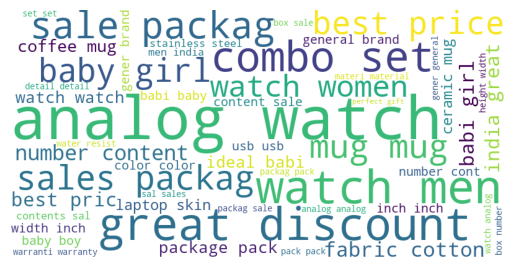

In [44]:
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_3_stem))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Visualisation des tokens du corpus pré-traité selon les catégories

In [45]:
#Séparation du dataframe en fonction des catégories :
# 0 = Baby Care
# 1 = Beauty and Personal Care
# 2 = Computers
# 3 = Home Decor and Festive Needs
# 4 = Home Furnishing
# 5 = Kitchen and Dining
# 6 = Watches
data_txt_sep_0 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 0]
data_txt_sep_1 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 1]
data_txt_sep_2 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 2]
data_txt_sep_3 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 3]
data_txt_sep_4 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 4]
data_txt_sep_5 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 5]
data_txt_sep_6 = data_txt_sep[data_txt_sep['cat_niv_1_num'] == 6]


In [46]:
#Création des différents corpus par catégories
corpus_0 = " ".join( data_txt_sep_0.description)
corpus_1 = " ".join( data_txt_sep_1.description)
corpus_2 = " ".join( data_txt_sep_2.description)
corpus_3 = " ".join( data_txt_sep_3.description)
corpus_4 = " ".join( data_txt_sep_4.description)
corpus_5 = " ".join( data_txt_sep_5.description)
corpus_6 = " ".join( data_txt_sep_6.description)

In [47]:
# Tokenisation des différents corpus par catégories
for i in range (0,7) :
  name_corpus = f"corpus_{i}"
  name_corpus_tokenised = f"corpus_tokenised_{i}"
  globals()[name_corpus_tokenised] = preprocess3(globals()[name_corpus], stopword_liste, 2, 700, 3, stem_lemm = "stem")
  print(f"Dans {name_corpus} : \n"
        f"Il y a  {len( globals()[name_corpus_tokenised])} tokens.\n"
        f"Il y a  {len(set( globals()[name_corpus_tokenised]))} tokens uniques.\n"
        f"***************************************************************")

Dans corpus_0 : 
Il y a  26469 tokens.
Il y a  3876 tokens uniques.
***************************************************************
Dans corpus_1 : 
Il y a  14946 tokens.
Il y a  2858 tokens uniques.
***************************************************************
Dans corpus_2 : 
Il y a  25893 tokens.
Il y a  3304 tokens uniques.
***************************************************************
Dans corpus_3 : 
Il y a  25310 tokens.
Il y a  5144 tokens uniques.
***************************************************************
Dans corpus_4 : 
Il y a  17914 tokens.
Il y a  2921 tokens uniques.
***************************************************************
Dans corpus_5 : 
Il y a  31159 tokens.
Il y a  3298 tokens uniques.
***************************************************************
Dans corpus_6 : 
Il y a  12287 tokens.
Il y a  1707 tokens uniques.
***************************************************************


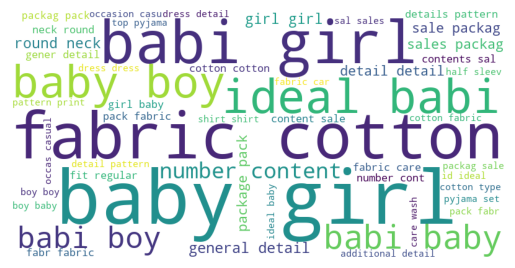

In [48]:
#  Visualisation des tokens de la catégorie "Baby Care"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_0))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

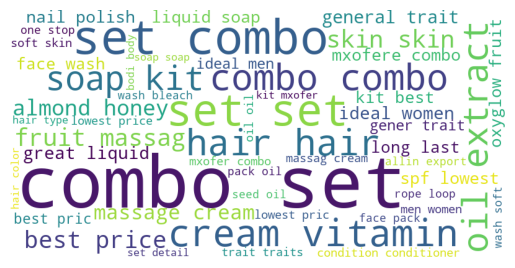

In [49]:
#  Visualisation des tokens de la catégorie "Beauty and Personal Care"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_1))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

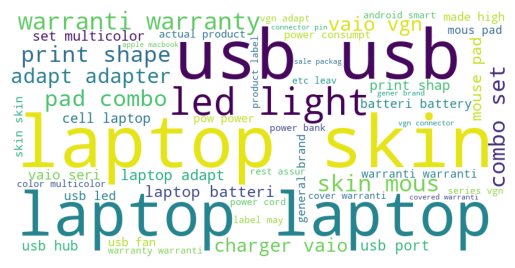

In [50]:
#  Visualisation des tokens de la catégorie "Computers"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

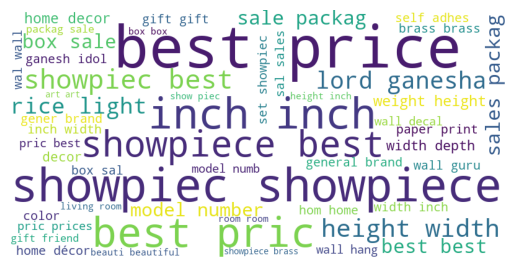

In [51]:
#  Visualisation des tokens de la catégorie "Home Decor and Festive Needs"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

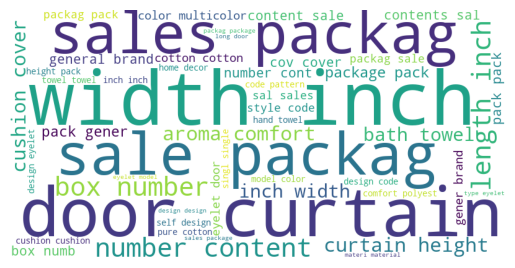

In [52]:
#  Visualisation des tokens de la catégorie "Home Furnishing"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_4))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

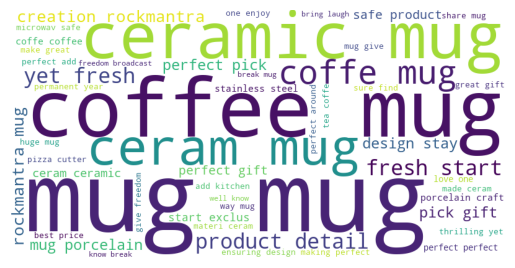

In [53]:
#  Visualisation des tokens de la catégorie "Kitchen and Dining"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

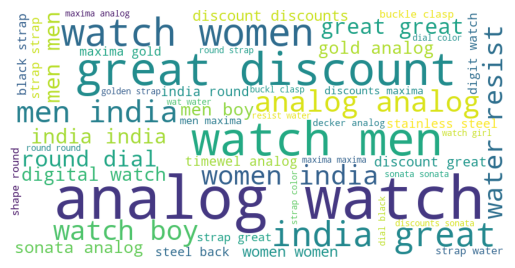

In [54]:
#  Visualisation des tokens de la catégorie "Watches"
wordcloud = WordCloud(
    width = 800, height = 400,
    background_color ='white', max_words = 50
    ).generate(" ".join(corpus_tokenised_6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Nettoyage final

In [55]:
data_txt_sep['description_preprocessed'] = data_txt_sep.description.apply(lambda txt: preprocess3(txt, stopword_liste, 2, 700, 3, stem_lemm="stem"))

data_txt_sep

,product_name,description,image,product_category_tree,cat_niv_1,cat_niv_2,_taille_description,cat_niv_1_num,description_preprocessed
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing,Curtains & Accessories,1420,4,"[key, eleg, polyest, multicolor, abstract, eye..."
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,444,0,"[sathiya, cotton, bath, towel, bath, towel, re..."
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,1258,0,"[key, eurospa, cotton, terri, face, towel, set..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,858,4,"[key, santosh, royal, fashion, cotton, print, ..."
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,1197,4,"[key, jaipur, print, cotton, floral, king, siz..."
...,...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,2432,0,"[oren, empow, extra, larg, self, adhes, sticke..."
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,1660,0,"[wallmantra, larg, vinyl, sticker, sticker, pa..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,262,0,"[uberlyf, extra, larg, pigment, polyvinyl, fil..."
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,210,0,"[wallmantra, medium, vinyl, sticker, sticker, ..."


In [56]:
data_txt_sep.to_csv("D:/tutorial-env/OCR/Projet6/data_txt_preprocessed.csv", index = False)

## Vectorisation :

###  Bags of words : CountVectorizer

In [57]:
# Convertir les listes de tokens en texte pour le vecteurisateur
data_txt_sep['processed_text_str'] = data_txt_sep['description_preprocessed'].apply(lambda tokens: ' '.join(tokens))

# Vectorisation
model = CountVectorizer()
X = model.fit_transform(data_txt_sep['processed_text_str'])

# Cration d'un DataFrame pour le stockage des résultats :
df_CountVec = pd.DataFrame(X.toarray(),columns=model.get_feature_names_out())

print(f"Dimension du DataFrame de vectorisation : {df_CountVec.shape}")

Dimension du DataFrame de vectorisation : (1050, 5351)


In [58]:
# Réduction de dimension par PCA

pca =  PCA(n_components = 500)
pca.fit(df_CountVec)


df_CountVec_pca = pca.transform(df_CountVec)

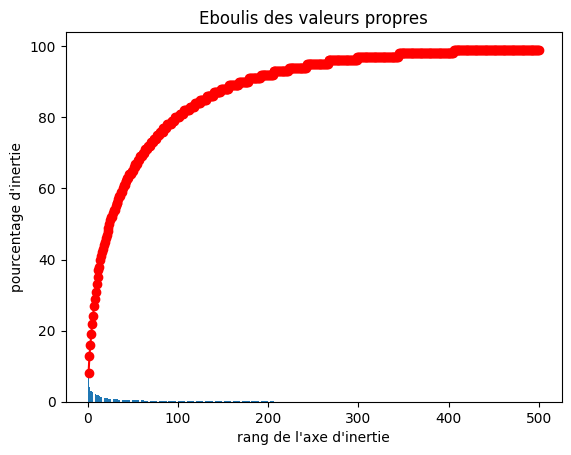

In [59]:
# Traçons le diagramme d'éboulis
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round()   #Somme cumulée des pourcentage d'explication de variance

x_list = range(1, 501)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c = "red",marker = 'o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block = False)

In [60]:
np.where(scree_cum == 95.)[0][0]

242

En prenant les 242 premiers composant de la PCA, on explique 95% de la matrice creuse.

In [61]:
df_CountVec_pca = pd.DataFrame(df_CountVec_pca[:,:242])
df_CountVec_pca.shape

(1050, 242)

In [62]:
df_CountVec_pca

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,-0.720531,3.072569,2.030958,2.590214,5.079917,3.205521,-4.035594,0.920283,0.705181,3.920050,...,1.629365,-0.239555,-0.397664,-0.981540,0.875608,-2.940703,-2.891871,1.206705,1.746431,-1.018505
1,-3.432209,0.933473,1.898887,3.423317,5.327410,3.398015,-4.265685,-3.696823,0.335012,-1.595276,...,-0.413652,-1.149562,0.231933,0.351181,-0.090939,-0.109771,0.064449,0.223965,2.341232,1.207626
2,-3.473394,13.026776,5.019882,14.396545,14.103402,8.032512,-7.841183,-9.162742,3.613956,-3.628984,...,0.801639,-3.255898,-0.102965,-0.195264,-0.335350,-0.489973,4.414619,2.960520,-2.249308,1.167865
3,-3.157920,8.035914,6.412066,7.024071,15.583629,11.511207,-12.110735,-11.895515,5.516552,-3.551766,...,3.161980,-0.040245,-0.172594,1.594285,1.961242,-0.793710,-0.465696,-1.785117,0.794124,-2.342927
4,-3.468145,14.763875,10.149020,9.504171,22.195097,16.587511,-16.021687,-17.649856,10.272500,-6.608264,...,2.170491,1.696167,-1.197283,-0.253926,0.227168,-2.315553,-0.322322,1.932491,0.648293,-2.709875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-1.045078,9.977056,2.976199,-1.924179,7.727528,6.681104,-2.246577,17.472060,10.729260,9.212130,...,0.341918,0.237653,-0.173382,0.052538,0.316610,0.211690,-0.151230,-0.041663,0.184632,-0.103595
1046,9.133191,23.090359,16.218907,-4.413637,16.969103,7.056929,1.154402,5.662257,12.485132,13.653227,...,0.164999,0.479422,0.188950,0.101444,-0.438295,-0.061764,0.045569,-0.141726,-0.745274,-0.440377
1047,-3.393988,-2.983129,-0.753400,-0.806112,-0.344916,-0.238776,-0.030798,1.974095,-2.505044,3.251083,...,-0.121046,-2.145688,0.530376,0.813865,-1.399244,0.315794,-1.149068,-2.086730,1.732311,1.330186
1048,-3.496958,-3.122167,-0.565733,-0.424178,-0.659653,-0.569021,-0.672257,1.742704,-2.540110,3.065058,...,0.517118,-0.301673,-0.613403,0.615343,0.737860,0.145482,-0.010354,0.594175,1.172115,0.145305


In [63]:
# Clustering par KMeans avec 7 clusters correspondants aux 7 catégories de niveau 1
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 7,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(df_CountVec_pca)

# Ajout des labels de cluster au dataframe
df_CountVec_pca['cluster'] = kmeans.labels_

In [64]:
df_CountVec_pca

,0,1,2,3,4,5,6,7,8,9,...,233,234,235,236,237,238,239,240,241,cluster
0,-0.720531,3.072569,2.030958,2.590214,5.079917,3.205521,-4.035594,0.920283,0.705181,3.920050,...,-0.239555,-0.397664,-0.981540,0.875608,-2.940703,-2.891871,1.206705,1.746431,-1.018505,0
1,-3.432209,0.933473,1.898887,3.423317,5.327410,3.398015,-4.265685,-3.696823,0.335012,-1.595276,...,-1.149562,0.231933,0.351181,-0.090939,-0.109771,0.064449,0.223965,2.341232,1.207626,0
2,-3.473394,13.026776,5.019882,14.396545,14.103402,8.032512,-7.841183,-9.162742,3.613956,-3.628984,...,-3.255898,-0.102965,-0.195264,-0.335350,-0.489973,4.414619,2.960520,-2.249308,1.167865,0
3,-3.157920,8.035914,6.412066,7.024071,15.583629,11.511207,-12.110735,-11.895515,5.516552,-3.551766,...,-0.040245,-0.172594,1.594285,1.961242,-0.793710,-0.465696,-1.785117,0.794124,-2.342927,0
4,-3.468145,14.763875,10.149020,9.504171,22.195097,16.587511,-16.021687,-17.649856,10.272500,-6.608264,...,1.696167,-1.197283,-0.253926,0.227168,-2.315553,-0.322322,1.932491,0.648293,-2.709875,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-1.045078,9.977056,2.976199,-1.924179,7.727528,6.681104,-2.246577,17.472060,10.729260,9.212130,...,0.237653,-0.173382,0.052538,0.316610,0.211690,-0.151230,-0.041663,0.184632,-0.103595,0
1046,9.133191,23.090359,16.218907,-4.413637,16.969103,7.056929,1.154402,5.662257,12.485132,13.653227,...,0.479422,0.188950,0.101444,-0.438295,-0.061764,0.045569,-0.141726,-0.745274,-0.440377,0
1047,-3.393988,-2.983129,-0.753400,-0.806112,-0.344916,-0.238776,-0.030798,1.974095,-2.505044,3.251083,...,-2.145688,0.530376,0.813865,-1.399244,0.315794,-1.149068,-2.086730,1.732311,1.330186,0
1048,-3.496958,-3.122167,-0.565733,-0.424178,-0.659653,-0.569021,-0.672257,1.742704,-2.540110,3.065058,...,-0.301673,-0.613403,0.615343,0.737860,0.145482,-0.010354,0.594175,1.172115,0.145305,0


In [65]:
df_CountVec_pca.groupby('cluster').size()

cluster
0    962
1     11
2     52
3      2
4     12
5      5
6      6
dtype: int64

Nous avons une répartition très déséquilibrée alors que la classification initiale du jeu de données est très équilibrée (150 pour chaque catégorie).

In [66]:
transformation = []
for i, el  in enumerate(matrix_cat.todense()[4,:].tolist()[0]):
    if el !=0:
        transformation.append((tfidf.get_feature_names()[i], el))
pd.DataFrame(transformation, columns=['mot', 'tfidf']).sort_values(by='tfidf', ascending=False).head(10)

NameError: name 'matrix_cat' is not defined




n-gramme : paire de mot qui reviennent fréquemment (bi ou tri-gramme)

-> matrice creuse

transofrmation en bag of word, tf/idf, ... sur corpus entier

reduction des vecteurs avec ACP puis clustering avec k means 7clusters et calculdu score ARI.

LDA / LDA vis = approche à comparer